In [14]:
!nvidia-smi

Sun Apr  7 10:26:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:01:01.0 Off |                    0 |
| N/A   26C    P8    14W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-04-07 10:26:31.959448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-07 10:26:32.008331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-07 10:26:32.010568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Import libraries.

In [17]:
import spacy
import re
import nltk
import string
import sklearn
import neattext as nt
import neattext.functions as nfx
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

/usr/local/lib/python3.8/dist-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/usr/local/lib/python3.8/dist-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-04-07 10:26:39.918930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 10:26:39.920036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one 

### Read data with pandas

In [18]:
data = pd.read_csv('augmented_dataset.csv')

### Inspecting the data.

In [19]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [20]:
data.groupby('cyberbullying_type').describe()

tweet_text         \
                         count unique   
cyberbullying_type                      
age                      15984  15975   
ethnicity                15922  15907   
gender                   15946  15880   
not_cyberbullying        15890  15846   
other_cyberbullying      15646  15613   
religion                 15996  15989   

                                                                             
                                                                   top freq  
cyberbullying_type                                                           
age                                             high school fuck bully    4  
ethnicity                                                      #ERROR!    6  
gender               after reading all the rape and homosexual joke...    3  
not_cyberbullying                                                 ROFL    2  
other_cyberbullying                                            5/14/15    2  
religion                       not all Muslim are from Islam you idiot    4

In [21]:
data['cyberbullying_type'].value_counts()

cyberbullying_type
religion               15996
age                    15984
gender                 15946
ethnicity              15922
not_cyberbullying      15890
other_cyberbullying    15646
Name: count, dtype: int64

In [22]:
data['cyberbullying_type'].nunique()

6

In [23]:
data['cyberbullying_type'].count()

95384

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95384 entries, 0 to 95383
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          95384 non-null  object
 1   cyberbullying_type  95384 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [25]:
data.shape

(95384, 2)

In [26]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [27]:
data.tail()

,tweet_text,cyberbullying_type
95379,"black ppl are n't expect to bash anything , de...",ethnicity
95380,Turner make not withhold his disappointment . ...,ethnicity
95381,iodine curse to God . This dense nigger bitch ...,ethnicity
95382,yea fuck you RT @ therealexel : IF YOURE angst...,ethnicity
95383,Bro . uracil get tantalum chill RT @ CHILLShra...,ethnicity


In [28]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [29]:
data.drop_duplicates(inplace=True)

In [30]:
data.shape

(95210, 2)

### Shuffle data and split it into training and test sets.

In [31]:
data_train, data_test = train_test_split(data, test_size = 0.3, random_state = 42, shuffle = True, stratify = data.cyberbullying_type)

### Remove hashtags, multiple spaces and user-handles.

In [32]:
data_train['tweet_text'] = data_train['tweet_text'].apply(nfx.remove_hashtags)
data_train.head()

,tweet_text,cyberbullying_type
85583,These celebrity are like those bully inch scho...,age
82050,My ma would get vaulting_horse astatine the id...,age
64289,anyhow you agree that information_technology W...,religion
11799,RT @damong__ I'm not sexist. But fuck marvel f...,gender
28029,RT @lexi4prez: this is why Pepsi is TRASH. how...,other_cyberbullying


In [33]:
# data_train['tweet_text'] = data_train['tweet_text'].apply(lambda x: nfx.remove_custom_pattern(x, term_pattern=r'&#\$ '))

data_train['tweet_text'] = data_train['tweet_text'].apply(nfx.remove_userhandles)

In [34]:
data_train.tail()

,tweet_text,cyberbullying_type
72826,@ FrankAlvarez see this thread . : phosphorus ...,other_cyberbullying
65571,Hahaha rich_person you get involve inch some t...,religion
1858,Fuck you if you hit nerds :/ bully Beatdown,not_cyberbullying
93959,get on her angstrom * * -- -- > RT “ @ tayyoun...,ethnicity
62505,make @ jansportnyc just brand angstrom “ homos...,gender


In [35]:
data_train['tweet_text'] = data_train['tweet_text'].apply(nfx.remove_multiple_spaces)
data_train.head()

,tweet_text,cyberbullying_type
85583,These celebrity are like those bully inch scho...,age
82050,My ma would get vaulting_horse astatine the id...,age
64289,anyhow you agree that information_technology W...,religion
11799,RT I'm not sexist. But fuck marvel for disresp...,gender
28029,RT this is why Pepsi is TRASH. how are you gon...,other_cyberbullying


In [36]:
data_train.tail()

,tweet_text,cyberbullying_type
72826,@ FrankAlvarez see this thread . : phosphorus ...,other_cyberbullying
65571,Hahaha rich_person you get involve inch some t...,religion
1858,Fuck you if you hit nerds :/ bully Beatdown,not_cyberbullying
93959,get on her angstrom * * -- -- > RT “ @ tayyoun...,ethnicity
62505,make @ jansportnyc just brand angstrom “ homos...,gender


In [37]:
data_train['tweet_text'] = data_train['tweet_text'].apply(nfx.remove_stopwords)
data_train.head()

,tweet_text,cyberbullying_type
85583,celebrity like bully inch school twit child ba...,age
82050,vaulting_horse astatine idea child Washington ...,age
64289,agree information_technology Washington angstr...,religion
11799,RT I'm sexist. fuck marvel disrespecting Thor ...,gender
28029,RT Pepsi TRASH. gonna nasty product shitty ads...,other_cyberbullying


In [38]:
data_train['tweet_text'] = data_train['tweet_text'].apply(nfx.remove_urls)
data_train.head()

,tweet_text,cyberbullying_type
85583,celebrity like bully inch school twit child ba...,age
82050,vaulting_horse astatine idea child Washington ...,age
64289,agree information_technology Washington angstr...,religion
11799,RT I'm sexist. fuck marvel disrespecting Thor ...,gender
28029,RT Pepsi TRASH. gonna nasty product shitty ads,other_cyberbullying


In [39]:
data_train['cyberbullying_type'].unique()

array(['age', 'religion', 'gender', 'other_cyberbullying',
       'not_cyberbullying', 'ethnicity'], dtype=object)

In [40]:
data_test['cyberbullying_type'].unique()

array(['gender', 'religion', 'age', 'other_cyberbullying',
       'not_cyberbullying', 'ethnicity'], dtype=object)

In [41]:
label_enc = LabelEncoder() 


In [42]:
data_train['cyberbullying_type'] = label_enc.fit_transform(data_train['cyberbullying_type'])
data_train.head()

,tweet_text,cyberbullying_type
85583,celebrity like bully inch school twit child ba...,0
82050,vaulting_horse astatine idea child Washington ...,0
64289,agree information_technology Washington angstr...,5
11799,RT I'm sexist. fuck marvel disrespecting Thor ...,2
28029,RT Pepsi TRASH. gonna nasty product shitty ads,4


In [43]:
data_test['cyberbullying_type'] = label_enc.transform(data_test['cyberbullying_type'])


In [44]:
data_test['cyberbullying_type'].unique()

array([2, 5, 0, 4, 3, 1])

In [45]:
data_train.dtypes

tweet_text            object
cyberbullying_type     int64
dtype: object

In [46]:
data_train['cyberbullying_type'].unique()

array([0, 5, 2, 4, 3, 1])

In [47]:
data_train['cyberbullying_type'].value_counts()

cyberbullying_type
5    11192
0    11183
1    11135
2    11116
3    11092
4    10929
Name: count, dtype: int64

#### Label encoder encodes data by alphabetical order. 

In [48]:
# data_train['cyberbullying_type'].value_counts()


# '''
# Cyberbullying labels are

# 0 - age
# 1 - ethnicity
# 2 - gender
# 3 - not_cyberbullying
# 4 - other_cyberbullying
# 5 - religion
# '''

### Tokenize train input text with bert's Autotokenizer that we imported earlier.

In [49]:
x_train = tokenizer(
#     text = x_train.tolist(),
    text = data_train['tweet_text'].tolist(),
    add_special_tokens = True,
    max_length = 100,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

In [50]:
x_train['input_ids']

<tf.Tensor: shape=(66647, 100), dtype=int32, numpy=
array([[  101, 10948,  1176, ...,     0,     0,     0],
       [  101, 13454,  1158, ...,     0,     0,     0],
       [  101,  5340,  1869, ...,     0,     0,     0],
       ...,
       [  101, 10259,  1855, ...,     0,     0,     0],
       [  101,  1126,  5700, ...,     0,     0,     0],
       [  101,   137,   179, ...,     0,     0,     0]], dtype=int32)>

### Building the model and fine-tuning the model.

The first value returned by BERT model at index 0 is the last hidden state, 1 means pooler_output
We need only the hidden state, so that we can add more layers and fine-tune the model.
We'll use functional API

In [51]:
max_len = 100


input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

# 0 is the last hidden state, 1 means pooler_output
# We need only the hidden state, so that we can add more layers and fine-tune the model.
# We'll use functional API
embeddings = bert(input_ids, attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(6, activation='sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

### Compile the model.

In [52]:
# Bert model requires a specific learning rate as stated in the huggingface website

optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

**Tokenize test data.**

In [53]:
x_test = tokenizer(
    text = data_test['tweet_text'].tolist(), 
    add_special_tokens = True,
    max_length = 100,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)


In [41]:

# Train the model with GPU
with tf.device('/GPU:0'):  # Specify GPU device
    bert_train = model.fit(
    x={'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
    y=to_categorical(data_train.cyberbullying_type),
    validation_data=(
        {'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']},to_categorical(data_test.cyberbullying_type)
    ),
    epochs=30,
    batch_size=100
    )

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


667/667 [==============================] - 1370s 2s/step - loss: 0.4839 - balanced_accuracy: 0.8039 - val_loss: 0.3703 - val_balanced_accuracy: 0.8494
Epoch 2/30
667/667 [==============================] - 1309s 2s/step - loss: 0.3530 - balanced_accuracy: 0.8554 - val_loss: 0.3564 - val_balanced_accuracy: 0.8584
Epoch 3/30
667/667 [==============================] - 1309s 2s/step - loss: 0.3240 - balanced_accuracy: 0.8682 - val_loss: 0.3481 - val_balanced_accuracy: 0.8625
Epoch 4/30
667/667 [==============================] - 1309s 2s/step - loss: 0.3072 - balanced_accuracy: 0.8770 - val_loss: 0.3462 - val_balanced_accuracy: 0.8627
Epoch 5/30
667/667 [==============================] - 1309s 2s/step - loss: 0.2939 - balanced_accuracy: 0.8813 - val_loss: 0.3475 - val_balanced_accuracy: 0.8628
Epoch 6/30
667/667 [==============================] - 1322s 2s/step - loss: 0.2857 - balanced_accuracy: 0.8846 - val_loss: 0.3499 - val_balanced_accuracy: 0.8622
Epoch 7/30
667/667 [===================

In [42]:
# bert_train = model.fit(
#     x={'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
#     y=to_categorical(data_train.cyberbullying_type),
#     validation_data=(
#         {'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']},to_categorical(data_test.cyberbullying_type)
#     ),
#     epochs=30,
#     batch_size=64
# )

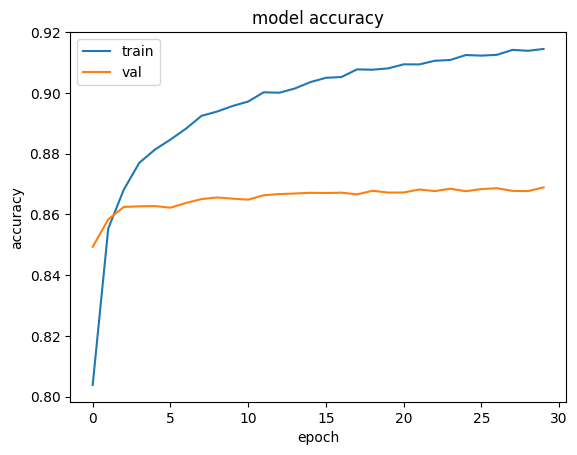

In [47]:
plt.plot(bert_train.history['balanced_accuracy'])
plt.plot(bert_train.history['val_balanced_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

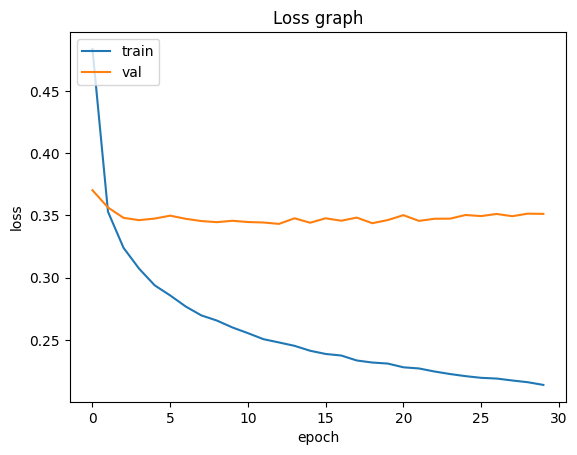

In [49]:
plt.plot(bert_train.history['loss'])
plt.plot(bert_train.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Results

In [50]:
# To use bert model later, we need to save both the weights and the model architecture and load them both. 
# We already saved the model architechture above when we downloaded the model.


model.save_weights('model_cyber.h5')

# To use the mode again, load it into memory
# model.load_weights('model_cyber.h5')

In [54]:
model.load_weights('model_cyber.h5')

In [55]:
pred_raw = model.predict({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']})

893/893 [==============================] - 175s 193ms/step


In [56]:
pred_raw[0]

array([0.00804324, 0.08588719, 0.99950933, 0.19726022, 0.14775369,
       0.03834678], dtype=float32)

In [57]:
y_pred = np.argmax(pred_raw, axis=1)

In [58]:
data_test.cyberbullying_type 

10732    2
71375    5
81389    0
16896    5
37995    0
        ..
85189    0
87043    0
69183    5
41504    1
61148    2
Name: cyberbullying_type, Length: 28563, dtype: int64

In [59]:
print(classification_report(data_test.cyberbullying_type, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4792
           1       0.98      0.98      0.98      4772
           2       0.85      0.92      0.88      4764
           3       0.75      0.58      0.65      4754
           4       0.69      0.79      0.73      4684
           5       0.96      0.96      0.96      4797

    accuracy                           0.87     28563
   macro avg       0.87      0.87      0.87     28563
weighted avg       0.87      0.87      0.87     28563



In [61]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(data_test.cyberbullying_type,y_pred))

0.8689213317928789


<Axes: >

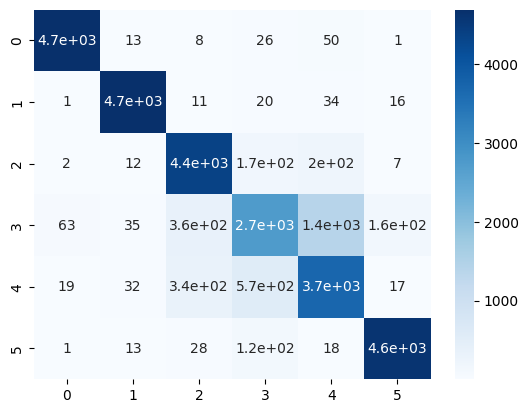

In [63]:
cm = confusion_matrix(data_test.cyberbullying_type, y_pred)
sns.heatmap(cm,cmap="Blues",annot=True)

In [57]:
##Few Test tweets belonging to different classes

In [103]:
tweet_samples = [
    "Kiddies have written 15 Christmas cards each... only another 48 each to go and that's only the ones for school!",
    "reading a manga and my friend texts me asking if i can meet up to discuss our project. That's okay, I guess.",
    "RT @TooBadDJs I'm not sexist at all, but I don't want to watch a ghostbusters film with just women in it #SoSueMe",
    "Somehow, I doubt it. @sellis94 More people would be satisfied with me as president than a women #notsexist #NeverYield",
    "Can you imagine this idiot calling for the Muslim vote?",
    "@lsarsour @abu__ramadi 3 executions? That's about one tenths of a days worth for Islamically correct ISIS.",
    "Girls who dress like this bullied me in middle school and high school",
    "im sitting outside with luna, and i swear on my life three girls walked past and i heard one say she looks like a lesbian. i am suddenly 17 and being bullied in high school again.",
    "Lebron James is a stupid cocky ass dumb nigger. Would of made a good slave but stupid fucks wanted equality.",
    "Lol this girl is posting inspiration memes and black lives matter quotes. But when your white friend called us a negro in lecture, your ears stopped working and your gum stayed closed. KMFT"
]

In [104]:
df = pd.DataFrame(tweet_samples, columns=['tweet_text'])

In [105]:
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_hashtags)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_userhandles)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_multiple_spaces)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_stopwords)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_urls)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_html_tags)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_emojis)
df['tweet_text'] = df['tweet_text'].apply(nfx.fix_contractions)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_special_characters)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_puncts)

In [110]:
df['tweet_text'].sample(5)

5    3 executions that is tenths days worth islamic...
9    lol girl posting inspiration memes black lives...
8    lebron james stupid cocky ass dumb nigger good...
0    kiddies written 15 christmas cards each 48 tha...
6    girls dress like bullied middle school high sc...
Name: tweet_text, dtype: object

In [115]:
max_length = 100
sample_data = tokenizer(
    text = df['tweet_text'].tolist(), 
    add_special_tokens = True,
    max_length = 100,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

In [116]:
sample_data.input_ids

<tf.Tensor: shape=(10, 100), dtype=int32, numpy=
array([[  101,  5102, 10831,  1637,  1405, 22572, 12937,  7941,  4802,
         1296,  3615,  1115,  1110,  3200,  1278,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  101,  3455,  9675,  1910,  6685,  4107,  2283,  6265,  1933,
         1115,  1110,  3008,  3319,   102,     0,     0,     0,     0,
            

In [117]:
sample_data.attention_mask

<tf.Tensor: shape=(10, 100), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [118]:
pred_samples = model.predict({'input_ids':sample_data['input_ids'], 'attention_mask':sample_data['attention_mask']})

1/1 [==============================] - 0s 147ms/step


In [127]:
pred_samples

array([[0.7068041 , 0.06427203, 0.10146379, 0.9817755 , 0.04339675,
        0.69286877],
       [0.24645545, 0.02459377, 0.1942196 , 0.9495136 , 0.981526  ,
        0.21965043],
       [0.00382482, 0.08843379, 0.9996766 , 0.59201616, 0.17919932,
        0.01996939],
       [0.04248816, 0.05629115, 0.9271012 , 0.86843646, 0.899191  ,
        0.10915016],
       [0.10030117, 0.12058902, 0.18452355, 0.27674884, 0.16217922,
        0.99976283],
       [0.08306578, 0.11156338, 0.19408228, 0.9664479 , 0.02970901,
        0.99075454],
       [0.9996959 , 0.00500708, 0.00908187, 0.04009407, 0.04571569,
        0.09853669],
       [0.9998172 , 0.00543283, 0.01167152, 0.00975757, 0.04535252,
        0.05399878],
       [0.5698747 , 0.9999865 , 0.87061554, 0.13190694, 0.1086812 ,
        0.5223906 ],
       [0.57154524, 0.99999166, 0.8355004 , 0.08631042, 0.08339687,
        0.5461901 ]], dtype=float32)

In [138]:
# i = 0
# max_index = np.argmax(pred_samples[i])
# original_label = label_enc.inverse_transform([max_index])[i]
# print(max_index)
# print(original_label)

3
not_cyberbullying


In [142]:
i = 0
for tuples in tweet_samples:
    max_index = np.argmax(pred_samples[i])
    original_label = label_enc.inverse_transform([max_index])[0]
    print("Tweet - " + str(tuples), end="\n")
    print("Bullying - " + str(original_label), end="\n\n")
    print('---')
    i += 1

Tweet - Kiddies have written 15 Christmas cards each... only another 48 each to go and that's only the ones for school!
Bullying - not_cyberbullying

---
Tweet - reading a manga and my friend texts me asking if i can meet up to discuss our project. That's okay, I guess.
Bullying - other_cyberbullying

---
Tweet - RT @TooBadDJs I'm not sexist at all, but I don't want to watch a ghostbusters film with just women in it #SoSueMe
Bullying - gender

---
Tweet - Somehow, I doubt it. @sellis94 More people would be satisfied with me as president than a women #notsexist #NeverYield
Bullying - gender

---
Tweet - Can you imagine this idiot calling for the Muslim vote?
Bullying - religion

---
Tweet - @lsarsour @abu__ramadi 3 executions? That's about one tenths of a days worth for Islamically correct ISIS.
Bullying - religion

---
Tweet - Girls who dress like this bullied me in middle school and high school
Bullying - age

---
Tweet - im sitting outside with luna, and i swear on my life three girl